# Dist-dip test illustration

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from helpers import cm2inch
matplotlib.style.use('styles.mplstyle')

from scipy.spatial.distance import pdist, squareform
from collections import Counter
from unidip.dip import dip_fn, diptst
from unidip.dip import _gcm_, _lcm_, _touch_diffs_

## Hartigan's dip test

### Background

![](https://skeptric.com/images/multimodal_pdf_cdf.png)
_Figure from https://skeptric.com/dip-statistic/_

Hartigan's dip test measures the distance between a distribution and it's closest unimodal approximation.
Intuitively, if this distance is small, it is likely unimodal, but if it is large, it is probably not unimodal.
A distribution is unimodal with mode $m$ if its cumulative distribution function (cdf) is convex below $m$ and concave after $m$. 
Indeed the mode need not be unique: the distribution can have a `flat' top.
In that case, the cdf is linearly increasing on the modal interval. 
The idea is to find a function that consists of a convex part, a linear part and a concave part that is as close to the cdf as possible. 
This will describe a unimodal distribution, and the distance between the two is the *dip statistic* we need.

Formally, measure the distance between two distribution functions as their largest difference $\rho(F, G) = \sup_x |F(x) - G(x)|$. If $\mathcal{U}$ is the collection of all unimodal distributions, then the dip statistic is defined as 
\begin{align}
    D(F) = \inf_{G \in \mathcal{U}} \rho(F, G).
\end{align}
Hartigan & Hartigan prove that $D(F) = d$ only if there is a nondecreasing function $G$ and some modal interval $[x_L, x_R]$ such that:

1. $G$ is the *greatest convex minorant* of $F+d$ on $(-\infty, x_L)$. That means that $G(x) is the largest convex function that lies below $F(x) + d$ on that interval.
2. $G$ has a constant, maximum slope on the modal interval $(x_L, x_R)$.
3. $G$ is the *least concave majorant* of $F-d$ on $(x_R, \infty)$. That means that $G(x) is the smallest concave function above $F(x)-d$ on that interval.
4. The dip is:
\begin{align}
    d 
        &= \sup_{x \notin (x_L, x_R)} |F(x) - G(x)| \\
        &\ge \sup_{x \in (x_L, x_R)} |F(x) - G(x)|
\end{align}

### Illustration

In [2]:
def illustrate_dip_statistic(idxs, cdf, left, right, dip, ax=None):
    if ax is None: ax = plt.gca()
    plt.sca(ax)

    L = len(left) - 1
    R = len(idxs) - len(right)
    xL = idxs[L]
    xR = idxs[R]

    plt.plot(idxs, cdf, 'k--', label='cdf', lw=.5)
    plt.plot(idxs[:R], cdf[:R]+dip, '0.5', lw=0.5, label='cdf $F \pm d$')
    plt.fill_between(idxs, cdf+dip, cdf-dip, color='0.5', alpha=.05,)
    plt.plot(idxs[L:], cdf[L:]-dip, '0.5', lw=0.5)

    plt.plot(idxs[:L+1], left + dip, '-', lw=1, 
        label='$G$, convex part')
    plt.plot([xL, xR], [left[-1] + dip, right[0] - dip], '-', lw=1, 
        label='$G$, modal interval')
    plt.plot(idxs[R:], right - dip, '-', lw=1, 
        label='$G$, concave part')

    plt.axvline(idxs[L], c='k', ls=':', lw=.5)
    plt.axvline(idxs[R], c='k', ls=':', lw=.5)

    plt.annotate('$x_L$', xy=(idxs[L], 1.1), ha='center', va='bottom', backgroundcolor='w')
    plt.annotate('$x_R$', xy=(idxs[R], 1.1), ha='center', va='bottom', backgroundcolor='w')

    plt.legend()

# plt.figure(figsize=cm2inch(10, 6))
# dip, (cdf, idxs, left, left_part, right, right_part) = dip_fn(dataset)
# illustrate_dip_statistic(idxs, cdf, left, right, dip)

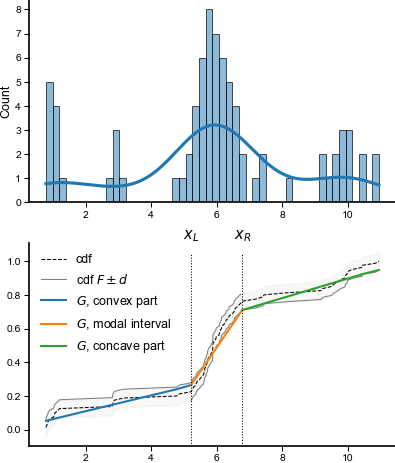

In [3]:
dataset = np.r_[
    np.random.normal(1, .15, size=10), 
    np.random.normal(3, .15, size=5), 
    np.random.normal(6, .6, size=50),
    np.random.normal(10, .4, size=15),
]

fig, axs = plt.subplots(2, figsize=cm2inch(8, 10))
sns.histplot(dataset, ax=axs[0], bins=50, kde=True)
dip, (cdf, idxs, left, left_part, right, right_part) = dip_fn(dataset)
illustrate_dip_statistic(idxs, cdf, left, right, dip, ax=axs[1])

In [33]:
dip, pval, (left_idx, right_idx) = diptst(dataset, is_hist=False, numt=1000)
dip, pval

(0.052720433519847724, 0.11188811188811189)

### Effect of bimodality

The dip of course correlates with the separation of bimodal data: the further the two modes are apart, the larger the dip.

In [75]:
mode_distances = np.linspace(0, .7, 50)
datasets = [
    np.r_[np.random.normal(0, .1, size=100), np.random.normal(d, .1, size=100)]
    for d in mode_distances
]

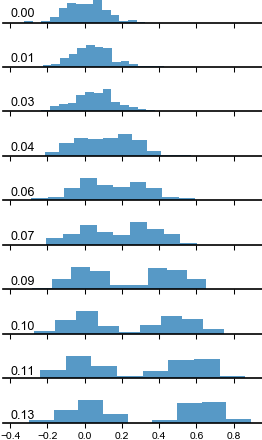

In [87]:
fig, axs = plt.subplots(len(datasets[::5]), sharex=True, figsize=cm2inch(5, 8), tight_layout=True)
for ax, dist, dataset in zip(axs, mode_distances, datasets[::5]):
    sns.histplot(dataset, ax=ax, lw=0)
    sns.despine(left=True)
    ax.set_ylabel(None)
    ax.set_yticks([])
    ax.annotate(f'{dist:.2f}', xy=(-.4,10), fontsize=6)

In [88]:
dips = []
pvals = []
for dataset in datasets:
    dip, pval, (left_idx, right_idx) = diptst(dataset, is_hist=False, numt=500)
    dips.append(dip)
    pvals.append(pval)

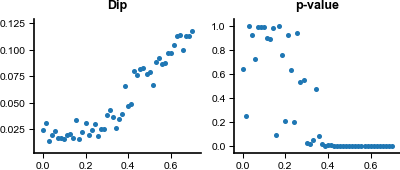

In [96]:
fig, axs = plt.subplots(1, 2, figsize=cm2inch(8, 3))
axs[0].scatter(mode_distances, dips, s=2)
axs[0].set_title('Dip')

axs[1].set_title('p-value')
plt.scatter(mode_distances, pvals, s=2)

### Computation

Here we visualize some aspects of the algorithm that computes the dip

In [4]:
def show_stage(idxs, cdf, left_part, left_touchpoints, right_part, 
    right_touchpoints, left_diffs, right_diffs, xl, xr, step):
    plt.figure(figsize=cm2inch(10, 6))

    plt.plot(idxs, cdf, 'k.-', lw=1, label='cumulative distr. function')

    plt.plot(idxs, left_part, '--.', lw=1, label='greatest convex minorant (left)')
    plt.plot(idxs[left_touchpoints], left_part[left_touchpoints], 
            'o', ms=7, c='C0', fillstyle='none', markeredgewidth=.5)

    plt.plot(idxs, right_part, ':.', lw=1, label='greatest convex majorant (right)')
    plt.plot(idxs[right_touchpoints], right_part[right_touchpoints], 
            'o', ms=7, c='C1', fillstyle='none', markeredgewidth=.5, 
            label='touchpoint (min. slope)')

    for t, diff in zip(left_touchpoints, left_diffs):
        plt.plot([idxs[t], idxs[t]], [left_part[t], left_part[t] + diff], 'C0-', lw=1)

    for t, diff in zip(right_touchpoints, right_diffs):
        plt.plot([idxs[t], idxs[t]], [right_part[t], right_part[t] - diff], 'C1-', lw=1)

    plt.axvline(idxs[xl], c='k', ls=':', lw=.5)
    plt.axvline(idxs[xr], c='k', ls=':', lw=.5)
    plt.annotate('xl', xy=(idxs[xl], 0))
    plt.annotate('xr', xy=(idxs[xr], 0))
    plt.legend()
    plt.title(f'Step {step}', x=0, ha='left', fontweight='bold')

In [5]:
# Copied from unidip.dip
def dip_fn2(dat, is_hist=False, just_dip=False):
    """
        Compute the Hartigans' dip statistic either for a histogram of
        samples (with equidistant bins) or for a set of samples.
    """
    if is_hist:
        histogram = dat
        idxs = np.arange(len(histogram))
    else:
        counts = Counter(dat)
        idxs = np.msort(list(counts.keys()))
        histogram = np.array([counts[i] for i in idxs])

    # check for case 1<N<4 or all identical values
    if len(idxs) <= 4 or idxs[0] == idxs[-1]:
        left = []
        right = [1]
        d = 0.0
        return d if just_dip else (d, (None, idxs, left, None, right, None))

    cdf = np.cumsum(histogram, dtype=float)
    cdf /= cdf[-1]

    work_idxs = idxs
    work_histogram = np.asarray(histogram, dtype=float) / np.sum(histogram)
    work_cdf = cdf

    D = 0
    left = [0]
    right = [1]
    step = 0
    while True:
        step += 1
        left_part, left_touchpoints = _gcm_(work_cdf-work_histogram, work_idxs)
        right_part, right_touchpoints = _lcm_(work_cdf, work_idxs)

        d_left, left_diffs = _touch_diffs_(left_part,
                                           right_part, left_touchpoints)
        d_right, right_diffs = _touch_diffs_(left_part,
                                             right_part, right_touchpoints)

        if d_right > d_left:
            xr = right_touchpoints[d_right == right_diffs][-1]
            xl = left_touchpoints[left_touchpoints <= xr][-1]
            d = d_right
        else:
            xl = left_touchpoints[d_left == left_diffs][0]
            xr = right_touchpoints[right_touchpoints >= xl][0]
            d = d_left

        left_diff = np.abs(left_part[:xl+1] - work_cdf[:xl+1]).max()
        right_diff = np.abs(right_part[xr:]
                            - work_cdf[xr:]
                            + work_histogram[xr:]).max()

        show_stage(
            work_idxs, work_cdf, left_part, left_touchpoints, right_part, 
            right_touchpoints, left_diffs, right_diffs, xl, xr,
            step
        )

        if d <= D or xr == 0 or xl == len(work_cdf):
            the_dip = max(np.abs(cdf[:len(left)] - left).max(),
                          np.abs(cdf[-len(right)-1:-1] - right).max())
            if just_dip:
                return the_dip/2
            else:
                return the_dip/2, (cdf, idxs, left, left_part, right, right_part)
        else:
            D = max(D, left_diff, right_diff)

        work_cdf = work_cdf[xl:xr+1]
        work_idxs = work_idxs[xl:xr+1]
        work_histogram = work_histogram[xl:xr+1]

        left[len(left):] = left_part[1:xl+1]
        right[:0] = right_part[xr:-1]

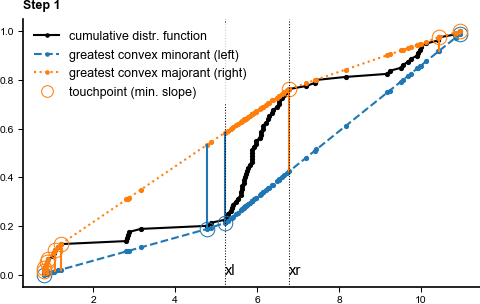

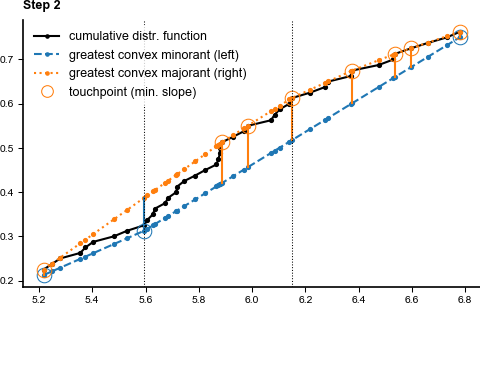

In [6]:
dip, (cdf, idxs, left, left_part, right, right_part) = dip_fn2(dataset, is_hist=False)

## Dist-dip

### Illustration

In [7]:
def show_bivariate_data(data):
    plt.figure(figsize=cm2inch(12, 4))
    plt.subplot(131)
    x, y = data.T
    plt.plot(x, y, '.', alpha=.2)
    plt.title('A. Data')

    plt.subplot(132)
    distances = pdist(data, metric='euclidean')
    plt.imshow(squareform(distances))
    plt.title('B. Distance matrix')

    plt.subplot(133)
    sns.kdeplot(distances, fill=True);
    plt.title('C. Distr. of pairwise distances');
    plt.tight_layout()

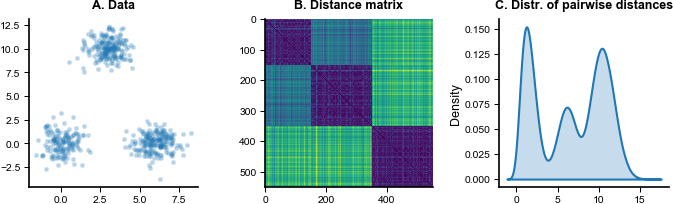

In [8]:
data = np.concatenate([
    np.random.multivariate_normal([0, 0], [[.5, 0], [0, 1]], 150), 
    np.random.multivariate_normal([6, 0], [[.5, 0], [0, 1]], 200),
    np.random.multivariate_normal([3, 10], [[.5, 0], [0, 1]], 200)
])
show_bivariate_data(data)
# plt.savefig('../figures/fig-experimental-setup/dist-dip-illustration.pdf')

/Users/bas/repos/papers/shapes-of-music/env/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


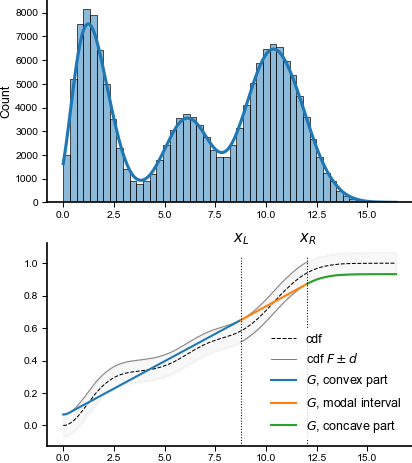

In [9]:
dists = pdist(data, metric='euclidean')
dip, (cdf, idxs, left, left_part, right, right_part) = dip_fn(dists)

fig, axs = plt.subplots(2, figsize=cm2inch(8, 10))
sns.histplot(dists, ax=axs[0], bins=50, kde=True)
dip, (cdf, idxs, left, left_part, right, right_part) = dip_fn(dists)
illustrate_dip_statistic(idxs, cdf, left, right, dip, ax=axs[1])

## TBR: Visualize aspects of implementation

In [10]:
from collections import Counter
from unidip.dip import _gcm_, _lcm_, _touch_diffs_

In [11]:
counts = Counter(dists)

# All unique values in the distribution, sorted
idxs = np.msort(list(counts.keys()))
assert np.all(idxs == np.msort(np.unique(dists)))

# The frequencies of all values
histogram = np.array([counts[i] for i in idxs], dtype=float)
histogram /= histogram.sum()

# We need at least 4 points, and they cannot all be identical
if len(idxs) <= 4 or idxs[0] == idxs[-1]:
    left = []
    right = [1]
    d = 0.0
    # return d if just_dip else (d, (None, idxs, left, None, right, None))

In [12]:
# Cumulative distribution function
cdf = np.cumsum(histogram, dtype=float)
cdf /= cdf[-1]

In [13]:
work_idxs = idxs
work_histogram = histogram
work_cdf = cdf

In [14]:
# Why the "- work_histogram"?
left_part, left_touchpoints = _gcm_(work_cdf - work_histogram, work_idxs)
right_part, right_touchpoints = _lcm_(work_cdf, work_idxs)
# touchpoints are indices of points where the cdf has minimum slope 

### Attempt to understand `_gcm_` 

touchpoints are indices of points where the cdf has minimum slope 
gcm = greatest convex minorant
lcm = least concave majorant

In [15]:
def show_progress(idxs, cdf, slopes, minslope_idx, minslope):
    plt.figure(figsize=cm2inch(6, 4))
    plt.plot(idxs, cdf, '.-', label='cdf', lw=1)
    plt.plot(idxs[:-1], slopes, 'x-', label='slope', lw=1)
    plt.plot(idxs[minslope_idx], slopes[minslope_idx], 'o', label='minimum slope')
    plt.legend()
show_progress(idxs, cdf, slopes, minslope_idx, minslope)

NameError: name 'slopes' is not defined

In [ ]:
work_cdf = cdf
work_idxs = idxs
gcm = [work_cdf[0]]
touchpoints = [0]
while len(work_cdf) > 1:
    distances = work_idxs[1:] - work_idxs[0]
    slopes = (work_cdf[1:] - work_cdf[0]) / distances
    minslope = slopes.min()
    minslope_idx = np.where(slopes == minslope)[0][0] + 1
    try:
        show_progress(work_idxs, work_cdf, slopes, minslope_idx, minslope)
    except: pass

    gcm.extend(work_cdf[0] + distances[:minslope_idx] * minslope)
    touchpoints.append(touchpoints[-1] + minslope_idx)
    work_cdf = work_cdf[minslope_idx:]
    work_idxs = work_idxs[minslope_idx:]

len(touchpoints), len(gcm)

# return np.array(np.array(gcm)), np.array(touchpoints)


## References

Adolfsson, A., Ackerman, M., & Brownstein, N. C. (2019). To cluster, or not to cluster: An analysis of clusterability methods. *Pattern Recognition, 88*, 13–26. https://doi.org/10/ggh2gq

Hartigan, J. A., & Hartigan, P. M. (1985). The Dip Test of Unimodality. *The Annals of Statistics, 13*(1), 70–84. https://doi.org/10/ctwtms

Kalogeratos, A., & Likas, A. (2012). Dip-means: An incremental clustering method for estimating the number of clusters. Advances in Neural Information Processing Systems 25, 2393–2401.

Maurus, S., & Plant, C. (2016). Skinny-dip: Clustering in a Sea of Noise. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 1055–1064. https://doi.org/10/gh274j


Informal introduction: https://skeptric.com/dip-statistic/

